In [3]:
import pandas as pd

df = pd.read_csv("C:/Users/azubo/Downloads/loan_data.csv")
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [8]:
df.isnull().sum()

Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

## For Categorical Columns → Fill with mode (most frequent value)
    These include:
    Gender, Married, Dependents, Self_Employed

In [9]:
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df['Married'] = df['Married'].fillna(df['Married'].mode()[0])
df['Dependents'] = df['Dependents'].fillna(df['Dependents'].mode()[0])
df['Self_Employed'] = df['Self_Employed'].fillna(df['Self_Employed'].mode()[0])

## For Numerical Columns → Fill with median or mode
LoanAmount: can be skewed, so use median
Loan_Amount_Term: usually fixed options (like 360), so use mode

In [11]:
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].median())
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0])

## For Binary Column (0/1): Credit_History

In [12]:
df['Credit_History'] = df['Credit_History'].fillna(df['Credit_History'].mode()[0])

## Check Class Balance
This helps you understand whether your dataset is balanced or imbalanced in terms of loan approvals vs denials:

Loan_Status
Y    422
N    192
Name: count, dtype: int64


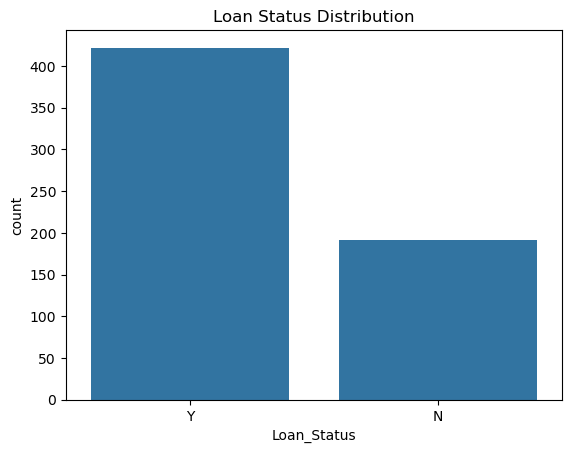

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check class distribution
print(df['Loan_Status'].value_counts())

# Optional: visualize class balance
sns.countplot(data=df, x='Loan_Status')
plt.title('Loan Status Distribution')
plt.show()


## Correlation Heatmap
This helps you see how numerical features are related. Use .corr() only on numeric features:

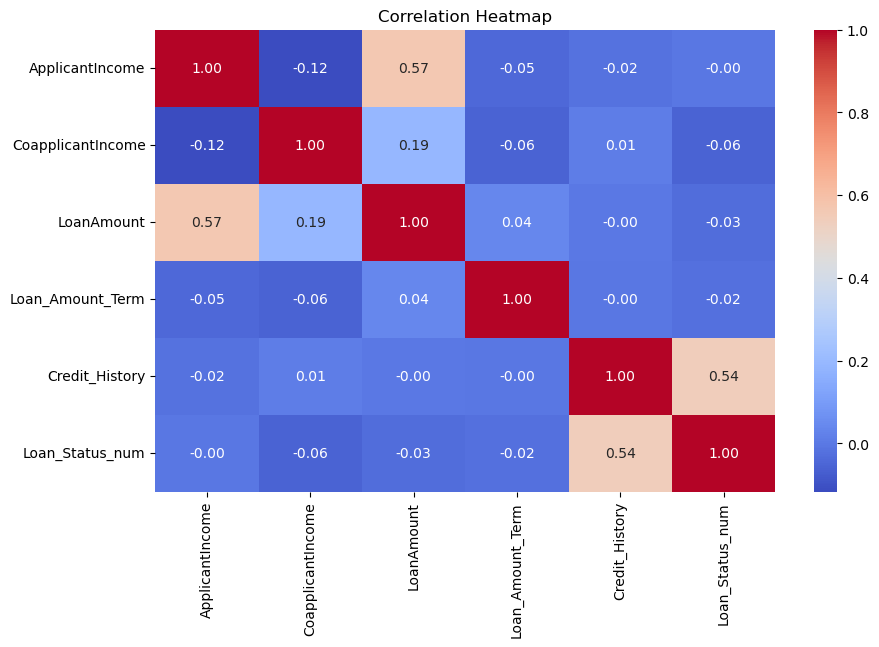

In [16]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Then plot the heatmap
plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


## Default Rate by Income
You can use a boxplot or histogram to compare income distributions:

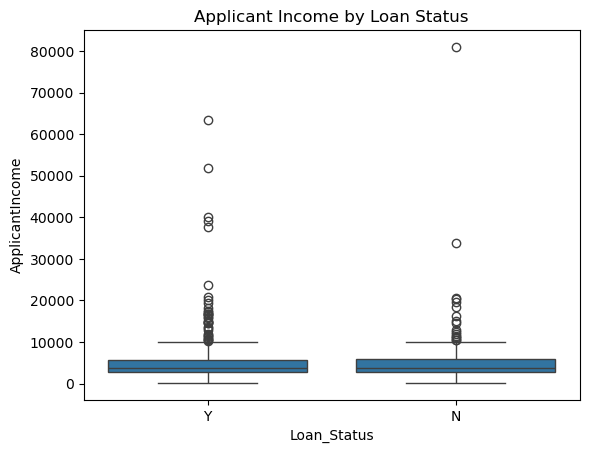

Loan_Status                N         Y
Income_Bin                            
(69.15, 16320.0]    0.314189  0.685811
(16320.0, 32490.0]  0.266667  0.733333
(32490.0, 48660.0]  0.250000  0.750000
(48660.0, 64830.0]  0.000000  1.000000
(64830.0, 81000.0]  1.000000  0.000000


In [17]:
# Boxplot to compare income for approved vs. rejected
sns.boxplot(data=df, x='Loan_Status', y='ApplicantIncome')
plt.title('Applicant Income by Loan Status')
plt.show()

# Optional: bin income and check default rate
df['Income_Bin'] = pd.cut(df['ApplicantIncome'], bins=5)
print(pd.crosstab(df['Income_Bin'], df['Loan_Status'], normalize='index'))

## Default Rate by Credit History
This is usually the strongest predictor in loan datasets:

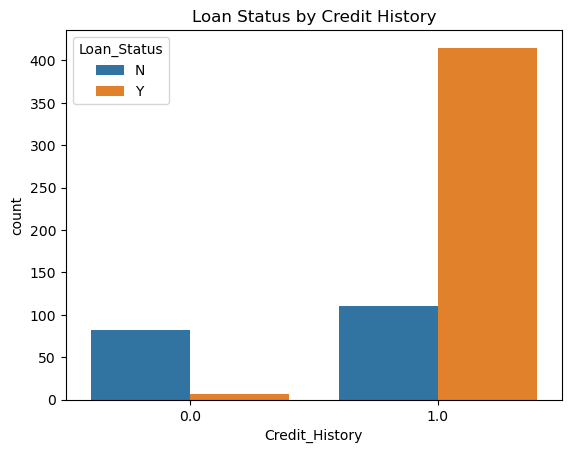

Loan_Status            N         Y
Credit_History                    
0.0             0.921348  0.078652
1.0             0.209524  0.790476


In [18]:
# Bar plot
sns.countplot(data=df, x='Credit_History', hue='Loan_Status')
plt.title('Loan Status by Credit History')
plt.show()

# Optional: cross-tab to see approval rates
print(pd.crosstab(df['Credit_History'], df['Loan_Status'], normalize='index'))


## Encode the target variable (Loan_Status)

In [20]:
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

## One-hot encode categorical features
Use pd.get_dummies() to convert object columns to numerical format:

In [21]:
# Create dummy variables for categorical columns
df_encoded = pd.get_dummies(df.drop('Loan_ID', axis=1), drop_first=True)


## Now split the data

In [22]:
from sklearn.model_selection import train_test_split

# Features and target
X = df_encoded.drop('Loan_Status', axis=1)
y = df_encoded['Loan_Status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


## Train Logistic Regression Model

In [24]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit model on scaled data
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Predict
y_pred = model.predict(X_test_scaled)


 ## Evaluate the Model

In [25]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        65
           1       1.00      1.00      1.00       120

    accuracy                           1.00       185
   macro avg       1.00      1.00      1.00       185
weighted avg       1.00      1.00      1.00       185


Confusion Matrix:
 [[ 65   0]
 [  0 120]]


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


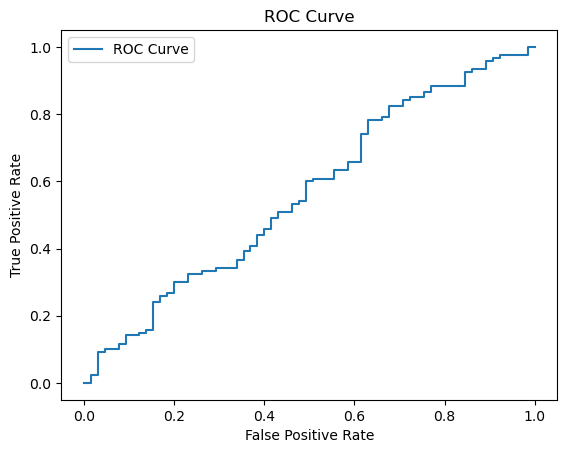

In [26]:
from sklearn.metrics import roc_auc_score, roc_curve

y_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


## Feature Importance

In [27]:
importance = model.coef_[0]
feature_names = X.columns
for i in range(len(importance)):
    print(f'{feature_names[i]}: {importance[i]}')


ApplicantIncome: -0.007130999488891482
CoapplicantIncome: -0.013986122515602278
LoanAmount: -0.0397872812291203
Loan_Amount_Term: 0.02926649954253447
Credit_History: 0.5051506235759439
Loan_Status_num: 4.040340628581281
Gender_Male: -0.018929054264326284
Married_Yes: 0.13241635296642484
Dependents_1: -0.06110730378650056
Dependents_2: 0.05108869737514301
Dependents_3+: 0.08539189798270105
Education_Not Graduate: -0.04646400952472185
Self_Employed_Yes: -0.003140245731691413
Property_Area_Semiurban: 0.19206954559895914
Property_Area_Urban: -0.00877829995260824
Income_Bin_(16320.0, 32490.0]: 0.043144102200164826
Income_Bin_(32490.0, 48660.0]: -0.04907289385470992
Income_Bin_(48660.0, 64830.0]: 0.0481780737900446
Income_Bin_(64830.0, 81000.0]: -0.05183450235397585


In [7]:
# Categorical
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df['Married'] = df['Married'].fillna(df['Married'].mode()[0])
df['Dependents'] = df['Dependents'].fillna(df['Dependents'].mode()[0])
df['Self_Employed'] = df['Self_Employed'].fillna(df['Self_Employed'].mode()[0])